In [1]:
import sys

sys.path.append('../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit
import sympy as sp
import scipy.stats as st

%matplotlib notebook

### Data

In [2]:
df = pd.read_csv('res1_df.csv')

In [3]:
x_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Cyt.to_numpy())
y_wt_full = np.mean(df[(df.Line == 'nwg201') & (df.Condition == 'wt')].Mem_tot.to_numpy())

print(x_wt_full)
print(y_wt_full)
print(y_wt_full / x_wt_full)

3268.514078922549
11036.742624360773
3.376685049494719


In [4]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy() / x_wt_full
y_wt = df[df.Line == 'nwg201'].Mem_tot.to_numpy() / y_wt_full

x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy() / x_wt_full
y_l109r = df[df.Line == 'nwg369'].Mem_tot.to_numpy() / y_wt_full

In [5]:
a = 0.01
b = 1e-6

xc = b
xm = 2.8893596260583494 * (y_wt_full / x_wt_full) * (1 / a) * b

weight_cyt = 1

In [6]:
cyts1 = np.r_[x_wt, x_l109r * 0]
cyts2 = np.r_[x_wt * 0, x_l109r]
cyts = np.c_[cyts1, cyts2]
mems = np.r_[y_wt, y_l109r]

### Functions

In [21]:
def fitting(model, cyts, mems, we=None, wd=None):
    # Ols fit
    popt, pcov = curve_fit(model, cyts.T, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y, we=we, wd=wd)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts.T, mems)
    params = regression.beta
            
    return params

In [22]:
def model(cyt, ka1, ka2, km):
    c1 = cyt[0] * xc
    m1 = c1 * km * (c1 * ka1 * km * (2 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1) + np.sqrt(
        4 * c1 ** 3 * ka1 ** 3 + 6 * c1 ** 2 * ka1 ** 2 * np.sqrt(
            4 * c1 * ka1 + 1) + 18 * c1 ** 2 * ka1 ** 2 + 8 * c1 * ka1 * np.sqrt(
            4 * c1 * ka1 + 1) + 12 * c1 * ka1 + 2 * np.sqrt(4 * c1 * ka1 + 1) + 2)) / (
                2 * c1 ** 2 * ka1 ** 2 + 2 * c1 * ka1 * np.sqrt(4 * c1 * ka1 + 1) + 4 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1)
    
    c2 = cyt[1] * xc
    m2 = c2 * km * (c2 * ka2 * km * (2 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1) + np.sqrt(
        4 * c2 ** 3 * ka2 ** 3 + 6 * c2 ** 2 * ka2 ** 2 * np.sqrt(
            4 * c2 * ka2 + 1) + 18 * c2 ** 2 * ka2 ** 2 + 8 * c2 * ka2 * np.sqrt(
            4 * c2 * ka2 + 1) + 12 * c2 * ka2 + 2 * np.sqrt(4 * c2 * ka2 + 1) + 2)) / (
                2 * c2 ** 2 * ka2 ** 2 + 2 * c2 * ka2 * np.sqrt(4 * c2 * ka2 + 1) + 4 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1)
    
    
    return m1 / xm + m2 / xm

### Fitting

In [24]:
p = fitting(model, cyts, mems)
print(np.log(p))

[8.38015085 6.55349062 5.93789851]


<IPython.core.display.Javascript object>


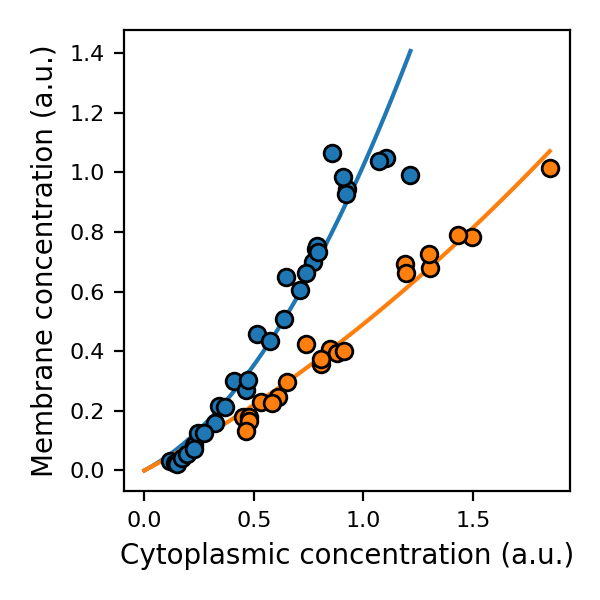

In [26]:
fig, ax = plt.subplots()

x = np.c_[np.linspace(0, max(x_wt), 100), np.zeros(100)]
ax.plot(x[:, 0], model(x.T, *p), c='tab:blue', zorder=0)
ax.scatter(x_wt, y_wt, c='tab:blue', edgecolors='k')

x = np.c_[np.zeros(100), np.linspace(0, max(x_l109r), 100)]
ax.plot(x[:, 1], model(x.T, *p), c='tab:orange', zorder=0)
ax.scatter(x_l109r, y_l109r, c='tab:orange', edgecolors='k')

ax.set_xlabel('Cytoplasmic concentration (a.u.)')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 3)
fig.tight_layout()

### Weight slider

<IPython.core.display.Javascript object>


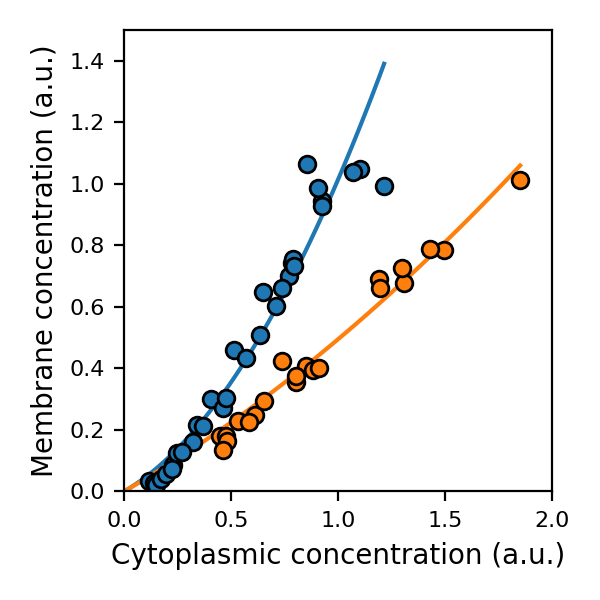

interactive(children=(IntSlider(value=1, description='we', max=10), IntSlider(value=1, description='wd', max=1…

In [34]:
import ipywidgets as widgets

fig, ax = plt.subplots()
@widgets.interact(we=(0, 10, 1), wd=(0, 10, 1))
def update(we=1, wd=1):
    ax.clear()
    p = fitting(model, cyts, mems, we=we, wd=wd)
    
    x = np.c_[np.linspace(0, max(x_wt), 100), np.zeros(100)]
    ax.plot(x[:, 0], model(x.T, *p), c='tab:blue', zorder=0)
    ax.scatter(x_wt, y_wt, c='tab:blue', edgecolors='k')

    x = np.c_[np.zeros(100), np.linspace(0, max(x_l109r), 100)]
    ax.plot(x[:, 1], model(x.T, *p), c='tab:orange', zorder=0)
    ax.scatter(x_l109r, y_l109r, c='tab:orange', edgecolors='k')

    ax.set_xlabel('Cytoplasmic concentration (a.u.)')
    ax.set_ylabel('Membrane concentration (a.u.)')
    ax.tick_params(axis='both', labelsize=8)

    ax.set_xlim(0, 2)
    ax.set_ylim(0, 1.5)
    
fig.set_size_inches(3, 3)
fig.tight_layout()